Dataset shape: (4847, 29)

First few rows:
   summary_nr Event Date                                      Abstract Text  \
0   220982664  8/10/2017  At 9:00 a.m. on August 10, 2017, an employee w...   
1   220973937  7/17/2017  At 9:45 a.m. on July 17, 2017, an employee was...   
2   220967632  6/30/2017  At 7:30 a.m. on June 30, 2017, an employee was...   
3   220969901  6/30/2017  At 2:00 p.m. on June 30, 2017, an employee was...   
4   220977748  6/23/2017  At 12:20 p.m. on June 23, 2017, an employee wa...   

                                   Event Description  \
0  EMPLOYEE'S FINGERS AMPUTATED WHILE OPERATING A...   
1  EMPLOYEE'S FINGER IS CAUGHT IN DRILL AND IS AM...   
2  EMPLOYEE IS HOSPITALIZED AFTER BEING INJURED I...   
3            EMPLOYEE FALLS FROM ROOF AND IS INJURED   
4  EMPLOYEE IS STRUCK BY PLYWOOD WHILE UNLOADING ...   

                                      Event Keywords con_end  \
0     FINGER,MECHANICAL POWER PRESS,AMPUTATION,GUARD       0   
1  CAUGHT IN,DRIV

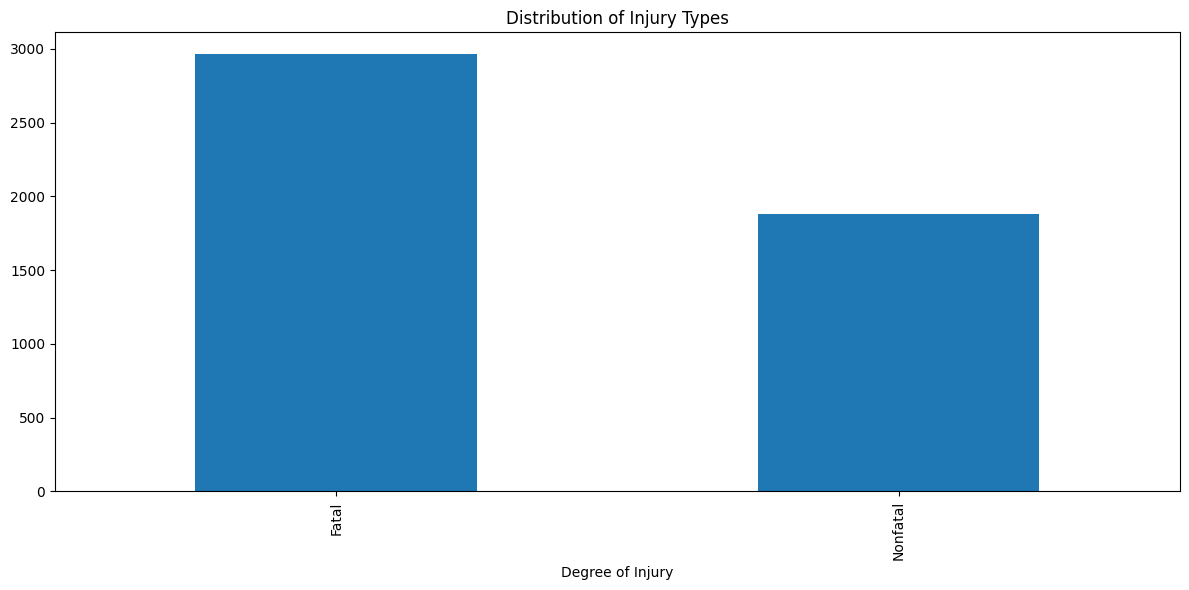

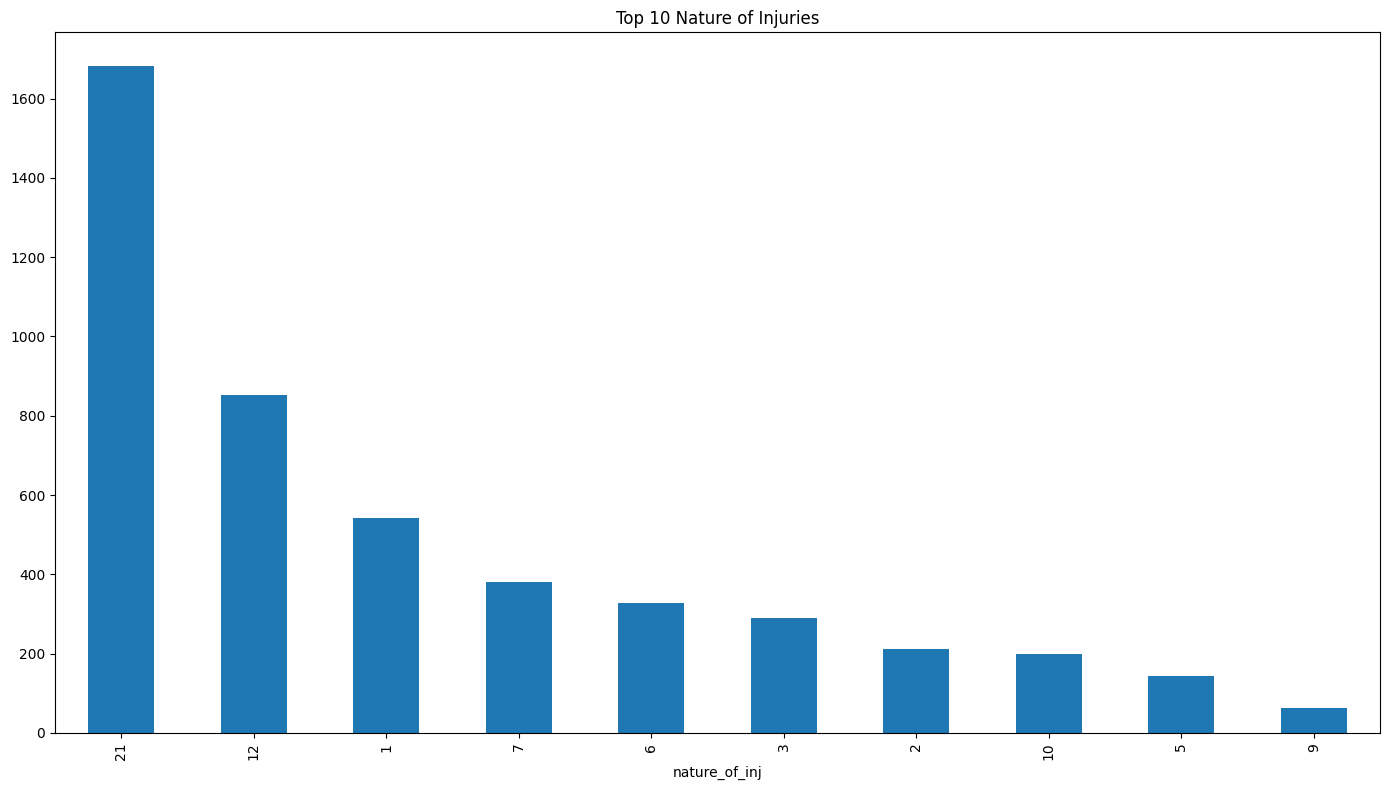

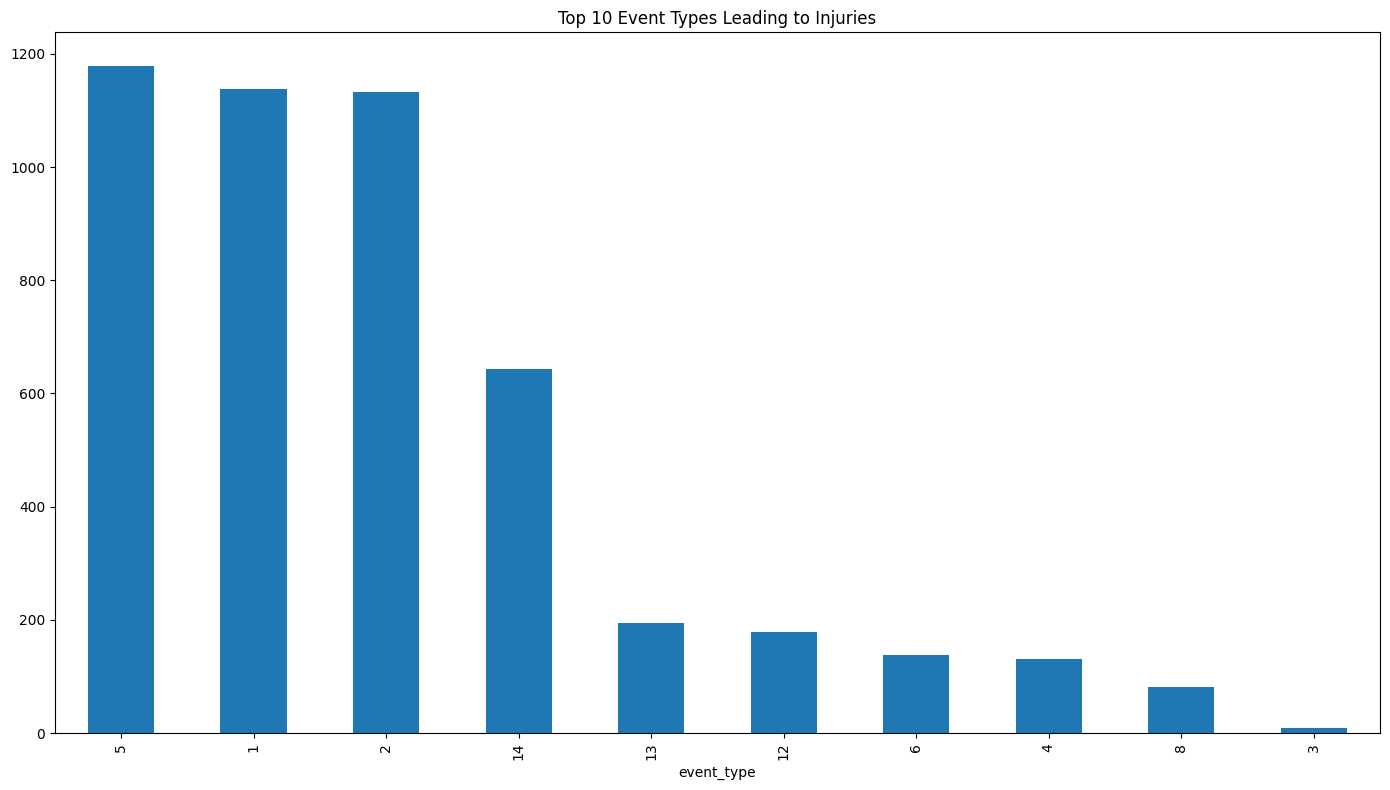

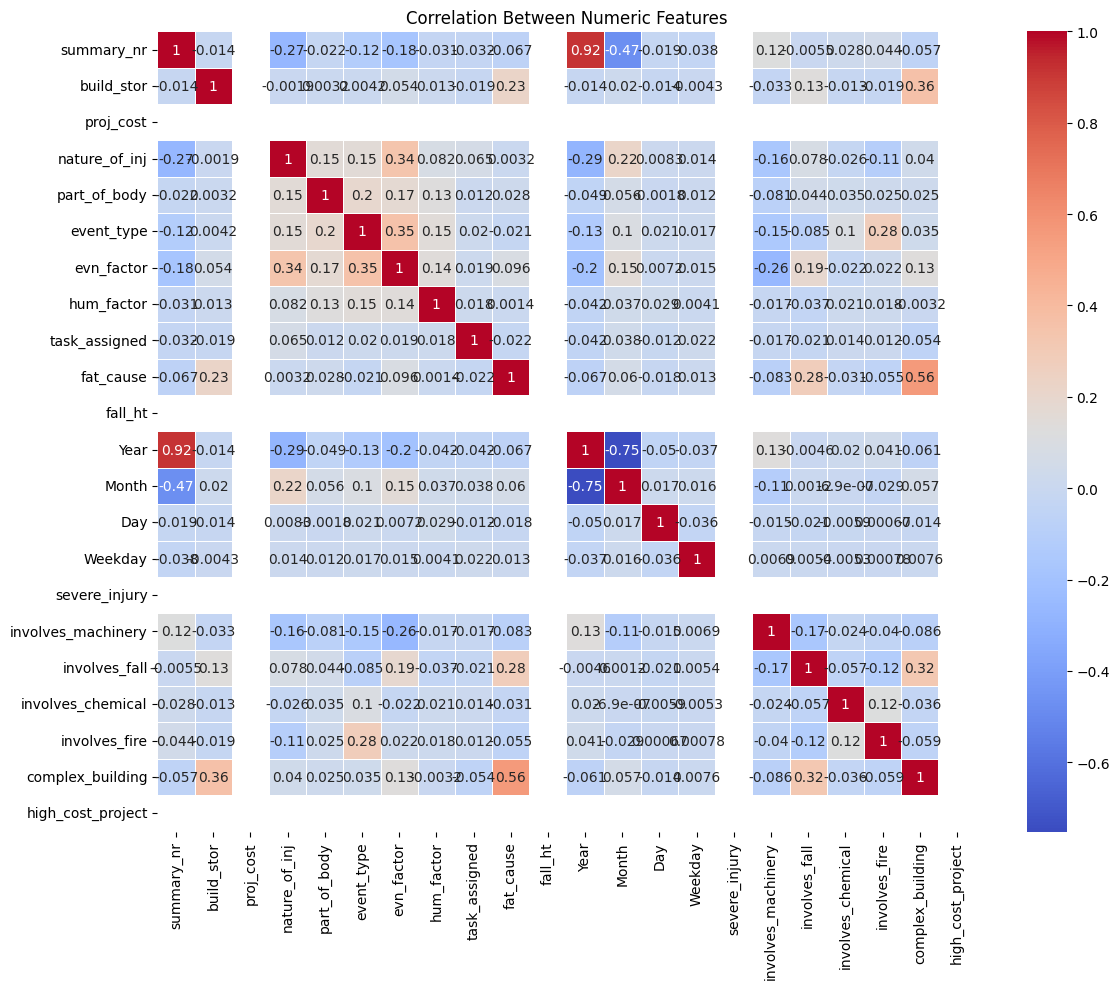

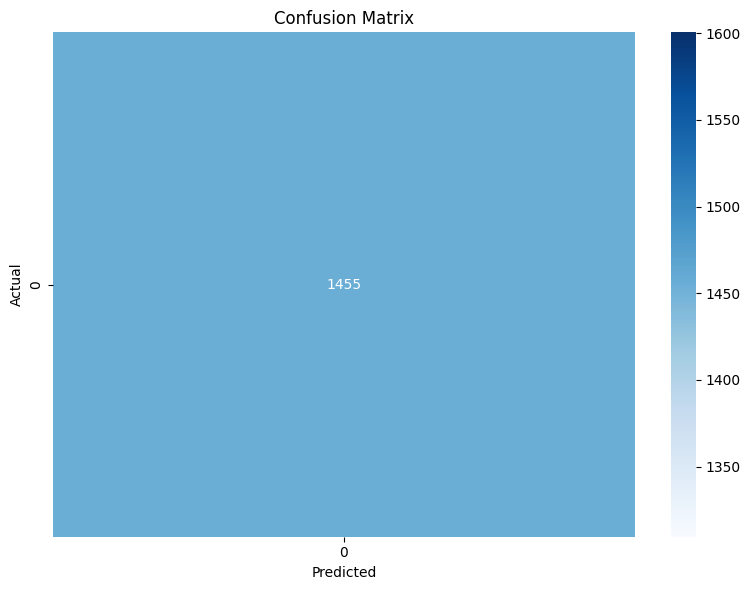

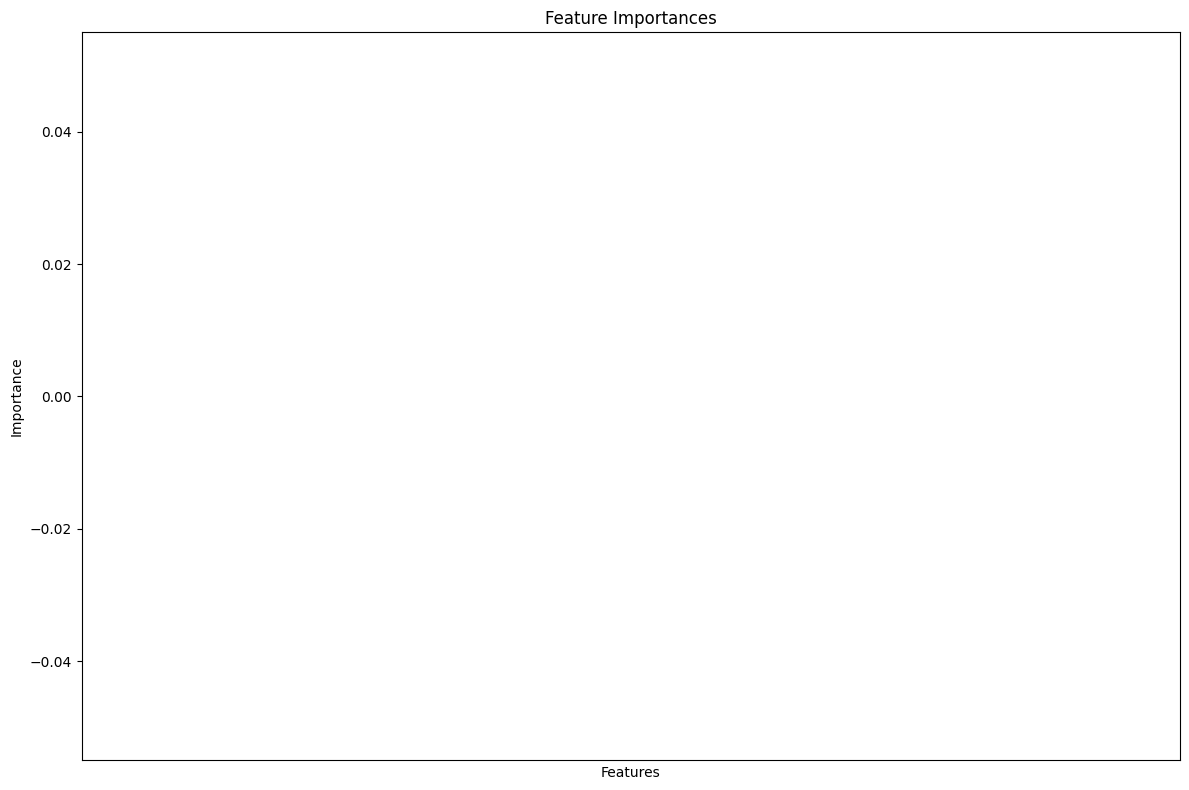

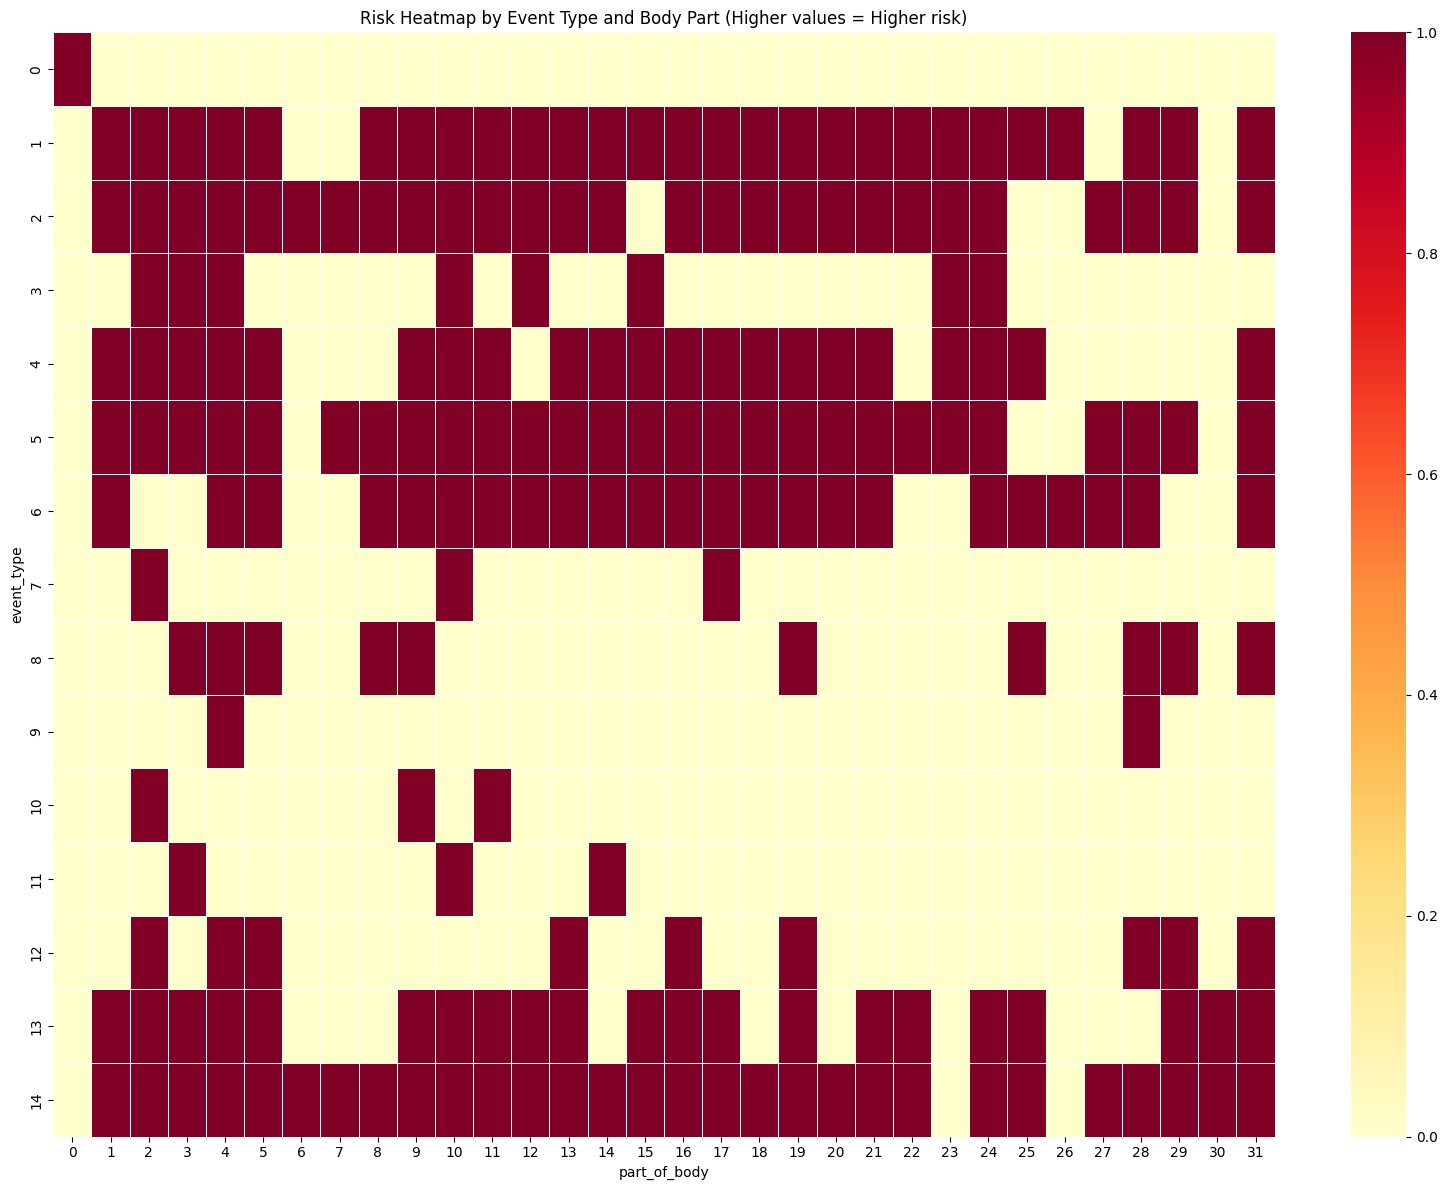

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 1. Load and Explore the Dataset
df = pd.read_csv('/content/OSHA HSE DATA_ALL ABSTRACTS 15-17_FINAL.csv')  # Replace with your file path

# Initial exploration
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

# 2. Data Cleaning and Preprocessing
# Convert date to datetime
df['Event Date'] = pd.to_datetime(df['Event Date'], errors='coerce')

# Extract date features
df['Year'] = df['Event Date'].dt.year
df['Month'] = df['Event Date'].dt.month
df['Day'] = df['Event Date'].dt.day
df['Weekday'] = df['Event Date'].dt.dayofweek

# Handle missing values
# For numeric columns, fill with median
numeric_cols = ['build_stor', 'proj_cost']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
    df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill with most frequent value
categorical_cols = ['con_end', 'proj_type', 'Degree of Injury',
                    'nature_of_inj', 'part_of_body', 'event_type',
                    'evn_factor', 'hum_factor', 'task_assigned']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# 3. Feature Engineering
# Create a binary target variable for severe injury prediction
# You can define 'severe' based on your criteria, such as amputation, fatality, etc.
severity_keywords = ['Amputation', 'Fatal', 'Fracture']
df['severe_injury'] = df['Degree of Injury'].str.contains('|'.join(severity_keywords), case=False, na=False).astype(int)

# Text Feature Engineering - Extract keywords from descriptions
# Create a binary feature for common hazard types
df['involves_machinery'] = df['Event Description'].str.contains('machine|press|drill|equipment', case=False, na=False).astype(int)
df['involves_fall'] = df['Event Description'].str.contains('fall|fell|height', case=False, na=False).astype(int)
df['involves_chemical'] = df['Event Description'].str.contains('chemical|acid|solution|exposure', case=False, na=False).astype(int)
df['involves_fire'] = df['Event Description'].str.contains('fire|burn|explosion', case=False, na=False).astype(int)

# Feature for building complexity (using building stories as a proxy)
df['complex_building'] = (df['build_stor'] > df['build_stor'].median()).astype(int)

# Feature for project cost magnitude
df['high_cost_project'] = (df['proj_cost'] > df['proj_cost'].median()).astype(int)

# 4. Exploratory Data Analysis
print("\n\nEDA for Workplace Accidents\n")

# Injury distribution
plt.figure(figsize=(12, 6))
df['Degree of Injury'].value_counts().plot(kind='bar')
plt.title('Distribution of Injury Types')
plt.tight_layout()
plt.savefig('injury_distribution.png')

# Nature of injuries
plt.figure(figsize=(14, 8))
df['nature_of_inj'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Nature of Injuries')
plt.tight_layout()
plt.savefig('nature_of_injuries.png')

# Event types leading to injuries
plt.figure(figsize=(14, 8))
df['event_type'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Event Types Leading to Injuries')
plt.tight_layout()
plt.savefig('event_types.png')

# Correlation between numeric features
numeric_df = df.select_dtypes(include=['number']).copy()
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Numeric Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# 5. Prepare Data for Modeling
# Select features for model
features = ['build_stor', 'proj_cost', 'Year', 'Month', 'Day', 'Weekday',
            'involves_machinery', 'involves_fall', 'involves_chemical',
            'involves_fire', 'complex_building', 'high_cost_project']

# Add categorical features with one-hot encoding
categorical_features = ['con_end', 'proj_type', 'nature_of_inj',
                        'part_of_body', 'event_type', 'evn_factor',
                        'hum_factor', 'task_assigned']

# Combine all features
all_features = features + categorical_features

# Define X and y
X = df[all_features]
y = df['severe_injury']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 6. Create preprocessing pipeline
# Define transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 7. Create and train the model
# Create a pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# 8. Evaluate the model
y_pred = best_model.predict(X_test)

print("\nModel Evaluation Results:")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# 9. Feature Importance Analysis
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_

    # Get the feature names after one-hot encoding
    # This is a safer approach that doesn't rely on matching lengths manually
    num_numeric_features = len(features)

    # Create indices for importance values
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances directly using indices
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks([])  # Hide x-ticks since we don't have reliable feature names
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importances.png')

    print("\nTop 10 Feature Importance Indices:")
    for i in range(min(10, len(importances))):
        print(f"Feature #{indices[i]}: {importances[indices[i]]:.4f}")

# 10. Create a Heatmap for Risk Zones (Bonus)
# This is a simplified approach - in a real scenario you would map to physical locations
# Here we'll use the event types and body parts as proxies for risk zones

# Create a cross-tabulation of event types and body parts
risk_heatmap = pd.crosstab(df['event_type'], df['part_of_body'],
                          values=df['severe_injury'],
                          aggfunc='mean').fillna(0)

plt.figure(figsize=(16, 12))
sns.heatmap(risk_heatmap, cmap='YlOrRd', annot=False, linewidths=0.5)
plt.title('Risk Heatmap by Event Type and Body Part (Higher values = Higher risk)')
plt.tight_layout()
plt.savefig('risk_heatmap.png')

# 11. Prediction Function for New Data
def predict_accident_risk(new_data):
    """
    Function to predict risk of severe injury for new data

    Parameters:
    new_data (dict): Dictionary containing feature values

    Returns:
    float: Probability of severe injury (or prediction if probabilities not available)
    """
    # Convert dictionary to DataFrame
    new_df = pd.DataFrame([new_data])

    # Ensure all necessary columns exist
    for col in all_features:
        if col not in new_df.columns:
            new_df[col] = 0

    # Make prediction safely
    try:
        # Try to get probability for class 1 (severe injury)
        prob_array = best_model.predict_proba(new_df[all_features])
        # Check if we have multiple classes in the output
        if prob_array.shape[1] > 1:
            prob = prob_array[0, 1]  # Get probability for class 1
        else:
            # If only one class, use the raw prediction (0 or 1)
            prob = best_model.predict(new_df[all_features])[0]
            print("Note: Only one class in prediction output. Returning binary prediction instead of probability.")
    except:
        # Fallback to binary prediction if probabilities aren't available
        prob = best_model.predict(new_df[all_features])[0]
        print("Note: Could not generate probabilities. Returning binary prediction instead.")

    return prob

# Example usage of prediction function
example_case = {
    'build_stor': 3,
    'proj_cost': 500000,
    'Year': 2023,
    'Month': 6,
    'Day': 15,
    'Weekday': 2,
    'involves_machinery': 1,
    'involves_fall': 0,
    'involves_chemical': 0,
    'involves_fire': 0,
    'complex_building': 0,
    'high_cost_project': 1,
    'con_end': 'Other building',
    'proj_type': 'New project',
    'nature_of_inj': 'Laceration',
    'part_of_body': 'Hand',
    'event_type': 'Caught in or between',
    'evn_factor': 'Other',
    'hum_factor': 'Position Inappropriate For Task',
    'task_assigned': 'Regularly Assigned'
}

risk_prob = predict_accident_risk(example_case)
print(f"\nPredicted risk/outcome for example case: {risk_prob}")

print("\nAnalysis Complete!")